## DeepSat (SAT-6) Airborne Dataset Analysis 
+ Purpose is to characterize the DeepSat Data/images into categories accurately
+ First step will be to be able to feed the data into a simple CNN using Batch Normalization and check the performance

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
path_a = os.getcwd()+"\datasets\crawford\deepsat-sat6"
print(f"path of the project : {path_a}")

# Print the contents of the path
from glob import glob
trainfiles, testfiles = [],[]
to_scan = path_a+"\*.csv"

for f in glob(to_scan):
    if "train" in f: 
        trainfiles.append(f)
    elif "test" in f: 
        testfiles.append(f)

# xtrain.iloc[0:0]
# ytrain.iloc[0:0]
# x_train.iloc[0:0]
# y_train.iloc[0:0]
xtrain = pd.read_csv(tf.gfile.Open(trainfiles[0]), nrows=50000, header=None) 
ytrain = pd.read_csv(tf.gfile.Open(trainfiles[1]), nrows=50000, header=None)
x_train = xtrain.values.reshape((xtrain.shape[0],28,28,4)).clip(0,255).astype(np.float32)
y_train = ytrain.values.astype(np.float32)

path of the project : C:\Public\xrelab\Xrelab\final-project\datasets\crawford\deepsat-sat6


In [3]:
print(trainfiles, testfiles)

['C:\\Public\\xrelab\\Xrelab\\final-project\\datasets\\crawford\\deepsat-sat6\\X_train_sat6.csv', 'C:\\Public\\xrelab\\Xrelab\\final-project\\datasets\\crawford\\deepsat-sat6\\y_train_sat6.csv'] ['C:\\Public\\xrelab\\Xrelab\\final-project\\datasets\\crawford\\deepsat-sat6\\X_test_sat6.csv', 'C:\\Public\\xrelab\\Xrelab\\final-project\\datasets\\crawford\\deepsat-sat6\\y_test_sat6.csv']


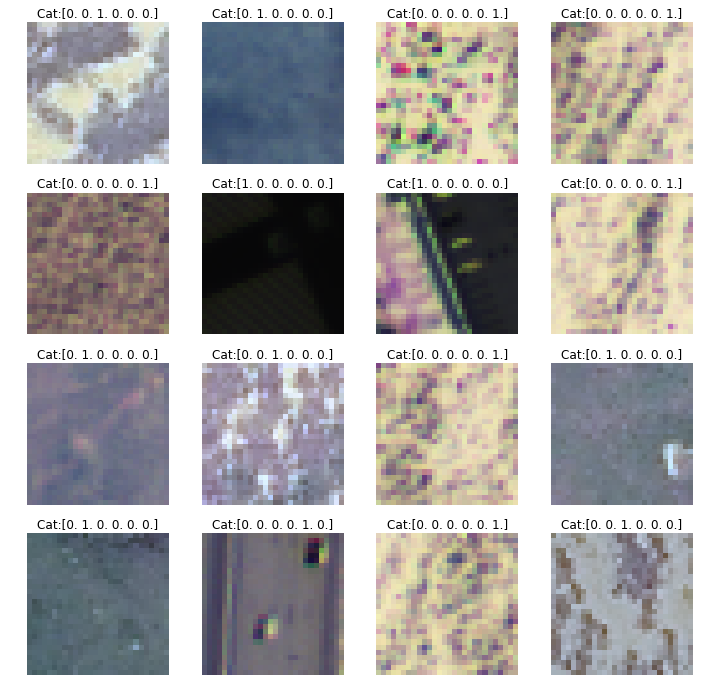

In [4]:
import matplotlib.pyplot as plt
c_train_x, c_train_y = x_train[0:16],y_train[0:16] 
fig, m_axs = plt.subplots(4, c_train_x.shape[0]//4, figsize = (12, 12))
for (x, y, c_ax) in zip(c_train_x, c_train_y, m_axs.flatten()):
    c_ax.imshow(x[:,:,:3],interpolation = 'none')
    c_ax.axis('off')
    c_ax.set_title('Cat:{}'.format(y))

In [5]:
xtest = pd.read_csv(tf.gfile.Open(testfiles[0]), nrows=4000, header=None) 
ytest = pd.read_csv(tf.gfile.Open(testfiles[1]), nrows=4000, header=None)
x_test = xtest.values.reshape((xtest.shape[0],28,28,4)).clip(0,255).astype(np.float32)
y_test = ytest.values.astype(np.float32)

## Put the Tensorflow model in Place 
+ Simple CNN with no Batch Normalization
+ Simple CNN with Batch Normalization
+ Simple CNN with Group Normalization

In [6]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 28, 28, 4) (50000, 6) (4000, 28, 28, 4) (4000, 6)


In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here
def cnn_model_fn(features, labels, mode, config):
    #Input layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 4])
    
    # Convolutional Layer #1
    conv1=tf.layers.conv2d(
            inputs=input_layer,
            filters=32,
            kernel_size=[5,5],
            padding="same",
            activation=tf.nn.relu6)
    
    print("Shape Conv1:" + str(conv1.shape))
    
    # First Max Pooling layer
    pool1=tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2) #strides=2 . Divide size by 2
    
    print("Shape Pool1:" + str(pool1.shape))
    
    # Convolutional Layer #2
    conv2=tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[5,5],
            padding="same",
            activation=tf.nn.relu6)
    
    print("Shape Conv2:" + str(conv2.shape))
    
    # Second Max Pooling layer
    pool2=tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2) #strides=2 . Divide size by 2
    
    print("Shape Pool2:" + str(pool2.shape))
    
    #Flatten Pool 2
    pool2_flat = tf.reshape(pool2, [-1, int(pool2.shape[1]) * int(pool2.shape[2]) * int(pool2.shape[3])])
    
    #Dense Layer
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu6)
    
    #Dropout
    dropout = tf.layers.dropout(inputs=dense1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Second Dense Layer
    dense2 = tf.layers.dense(inputs=dropout, units=256, activation=tf.nn.relu6)
    
    #Output layer final
    logits = tf.layers.dense(inputs=dense2, units=labels.shape[1])
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    # Predict Mode
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Loss Function
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)
    
    
    # Classification Metrics
    # accuracy
    acc  = tf.metrics.accuracy(labels=tf.argmax(labels,1), predictions=predictions['classes'])
    
    # Precision
    prec = tf.metrics.precision(labels=tf.argmax(labels,1), predictions=predictions['classes'])
    
    # Recall
    rec = tf.metrics.recall(labels=tf.argmax(labels,1), predictions=predictions['classes'])
    
    # F1 Score
    f1 = 2 * acc[1] * rec[1] /(prec[1] + rec[1]) 
    
    
    #TensorBoard Summary
    tf.summary.scalar('Accuracy', acc[1])
    tf.summary.scalar('Precision', prec[1])
    tf.summary.scalar('Recall', rec[1])
    tf.summary.scalar('F1Score', f1)
    tf.summary.histogram('Probabilities', predictions['probabilities'])
    tf.summary.histogram('Classes', predictions['classes'])
    
    summary_hook = tf.train.SummarySaverHook(summary_op=tf.summary.merge_all(),save_steps=1)
    
    # Learning Rate Decay (Exponential)
    learning_rate = tf.train.exponential_decay(learning_rate=1e-04,
                                               global_step=tf.train.get_global_step(),
                                               decay_steps=10000, 
                                               decay_rate=0.96, 
                                               staircase=True,
                                               name='lr_exp_decay')
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    
    # Evaluation Metrics
    eval_metric_ops = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
    }
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [12]:
sat6_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="C:/Public/xrelab/Xrelab/final-project/cnn_model",
                                         config=tf.estimator.RunConfig())
tensors_to_log={"probabilities":"softmax_tensor"}
logging_hook=tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=1)
# Training input function
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x_train},
                                                    y=y_train,
                                                    batch_size=512,
                                                    num_epochs=1,
                                                    shuffle=True)
# Evaluation input function
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x_test},
                                                   y=y_test,
                                                   num_epochs=1,
                                                   shuffle=False)
for i in range(10):
    sat6_classifier.train(input_fn=train_input_fn, hooks=[logging_hook])
    eval_results=sat6_classifier.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Using config: {}
Shape Conv1:(?, 28, 28, 32)
Shape Pool1:(?, 14, 14, 32)
Shape Conv2:(?, 14, 14, 64)
Shape Pool2:(?, 7, 7, 64)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /cnn_model\model.ckpt.
INFO:tensorflow:loss = 3.0038042, step = 1
INFO:tensorflow:probabilities = [[0.40062025 0.42893562 0.01859248 0.01207637 0.00021373 0.13956156]
 [0.31060302 0.36972848 0.10780052 0.19884922 0.00046813 0.01255057]
 [0.02065442 0.00460641 0.8146003  0.00477983 0.02163759 0.13372152]
 ...
 [0.0025458  0.6244302  0.3218971  0.01702832 0.00518367 0.02891493]
 [0.03729572 0.2179503  0.3784447  0.00821696 0.00395384 0.35413846]
 [0.00872116 0.96694493 0.00328777 0.01276697 0.00545871 0.00282049]]
INFO:tensorflow:probabilities = [[0.44498163 0.01442065 0.14231014 0.36954033 0.00015608 0.02859116]
 [0.00601732 0.45248473 0.03508943 0.28591725 0.04626175 0.17422953]
 [0.01024153 0.0083362  0.00304127 0.04647023 0.00024632 0.93166447]
 ...
 [0.0

INFO:tensorflow:probabilities = [[0.05306472 0.03273438 0.06145499 0.5260916  0.04904776 0.27760655]
 [0.08088375 0.14345184 0.07514667 0.68265265 0.01100021 0.00686485]
 [0.16330476 0.56667405 0.04370711 0.18906751 0.03404912 0.00319756]
 ...
 [0.02266655 0.1685512  0.17687277 0.59011996 0.04073233 0.00105721]
 [0.00006088 0.00007881 0.00649399 0.00073852 0.00021694 0.9924109 ]
 [0.02015173 0.22063357 0.22250277 0.47495455 0.00633487 0.0554225 ]] (2.773 sec)
INFO:tensorflow:probabilities = [[0.00107932 0.00313384 0.0004501  0.00068988 0.00010776 0.9945391 ]
 [0.01330205 0.96872944 0.00018253 0.01492374 0.00007845 0.00278367]
 [0.01015981 0.00522722 0.01053487 0.0033957  0.00097454 0.96970785]
 ...
 [0.00044281 0.00119705 0.00133583 0.00235748 0.00073971 0.9939272 ]
 [0.02842238 0.03945167 0.71114695 0.15792757 0.00383208 0.05921928]
 [0.00424737 0.00361823 0.00256999 0.0026711  0.00080455 0.9860888 ]] (2.958 sec)
INFO:tensorflow:probabilities = [[0.05209919 0.00201015 0.29363656 0.070

INFO:tensorflow:probabilities = [[0.00907334 0.07095958 0.24018715 0.6643081  0.01487583 0.00059599]
 [0.11481138 0.06549033 0.32124594 0.21881609 0.27162164 0.00801456]
 [0.06042136 0.00205267 0.00034396 0.00820407 0.00058088 0.92839706]
 ...
 [0.00106243 0.00041307 0.00019556 0.00013408 0.00093535 0.9972595 ]
 [0.20822053 0.12707725 0.44793946 0.09432297 0.00874077 0.11369905]
 [0.08480051 0.12098118 0.5886892  0.1443637  0.0081704  0.05299507]] (2.388 sec)
INFO:tensorflow:probabilities = [[0.05701346 0.5573385  0.1811171  0.10824701 0.02732711 0.06895675]
 [0.00273917 0.00067913 0.00002327 0.00027351 0.00013951 0.99614537]
 [0.01502304 0.16292033 0.01446848 0.79475343 0.0127604  0.00007427]
 ...
 [0.0062151  0.00005964 0.00020035 0.00044676 0.0000849  0.9929932 ]
 [0.00113549 0.9761789  0.0038379  0.00589608 0.01224192 0.00070961]
 [0.01857955 0.9214996  0.00177997 0.05785248 0.00020994 0.00007853]] (2.396 sec)
INFO:tensorflow:probabilities = [[0.0189291  0.07616249 0.36278373 0.535

INFO:tensorflow:probabilities = [[0.01395941 0.25915483 0.02688033 0.6849952  0.00549254 0.00951773]
 [0.5476529  0.14800525 0.08711223 0.0124885  0.14967701 0.05506405]
 [0.11342605 0.00840728 0.02681432 0.00666479 0.3988948  0.4457927 ]
 ...
 [0.22340342 0.1567859  0.3975982  0.21529418 0.00342053 0.00349777]
 [0.11173212 0.43421674 0.26076996 0.12781306 0.063309   0.00215911]
 [0.11821858 0.6506644  0.06560063 0.13092889 0.01112517 0.02346234]] (2.446 sec)
INFO:tensorflow:probabilities = [[0.00521001 0.9732905  0.0084455  0.01283374 0.00016943 0.00005087]
 [0.00532794 0.12558317 0.6783814  0.184973   0.00567646 0.00005798]
 [0.00086003 0.00042469 0.00148211 0.00052641 0.00007228 0.99663454]
 ...
 [0.00509483 0.00089433 0.00104236 0.00852535 0.00224612 0.98219705]
 [0.00018013 0.00001072 0.000407   0.00004764 0.0014277  0.99792683]
 [0.00405951 0.01364643 0.00326606 0.0063767  0.00243297 0.97021836]] (2.389 sec)
INFO:tensorflow:probabilities = [[0.11906048 0.07431131 0.7099281  0.072

INFO:tensorflow:probabilities = [[0.00690962 0.9720661  0.00678673 0.00946421 0.00462437 0.00014895]
 [0.00135554 0.0000227  0.0003112  0.00002073 0.00059811 0.99769175]
 [0.00541657 0.00031047 0.00016676 0.00001894 0.00047842 0.99360883]
 ...
 [0.08356784 0.5341686  0.11480149 0.22489828 0.0408939  0.00166982]
 [0.03004171 0.04101926 0.55341023 0.27687576 0.07886732 0.01978573]
 [0.07262311 0.22484107 0.26393527 0.41447207 0.01140726 0.0127212 ]] (2.759 sec)
INFO:tensorflow:probabilities = [[0.00170454 0.09078958 0.54011846 0.35621193 0.01036405 0.00081149]
 [0.00055911 0.00000546 0.00003938 0.00005233 0.00165288 0.9976909 ]
 [0.00298533 0.00627746 0.7846696  0.20367123 0.00109324 0.00130321]
 ...
 [0.00513786 0.00063131 0.01623359 0.00251841 0.01567931 0.9597996 ]
 [0.04393123 0.8141294  0.03535475 0.10389667 0.00064823 0.00203978]
 [0.01038347 0.23675273 0.38465548 0.3661254  0.00171262 0.00037022]] (2.575 sec)
INFO:tensorflow:probabilities = [[0.00772898 0.7317478  0.00785782 0.240

INFO:tensorflow:probabilities = [[0.03095884 0.00298599 0.30851614 0.6569126  0.0005546  0.00007179]
 [0.02591694 0.8499563  0.01473095 0.10341607 0.00557783 0.00040188]
 [0.01247782 0.8369164  0.01476331 0.13241763 0.00154624 0.00187863]
 ...
 [0.03386117 0.867435   0.01364467 0.06119747 0.02224501 0.00161663]
 [0.00015093 0.00024154 0.00179744 0.00003876 0.00235767 0.9954137 ]
 [0.01993373 0.11378642 0.41529477 0.44423172 0.00426488 0.00248845]] (2.529 sec)


KeyboardInterrupt: 